# Avancement projet Anomalies, 17 mars

## Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

## Importation des données

On lit les données d'apprentissage et de test et on forme une liste de toutes les données contenant au total 428 vols.

In [6]:
path_appr = "../Donnees_projet/Ensemble_apprentissage/"
path_test = "../Donnees_projet/Ensemble_test/"
#path_appr = "../../4A/Projet/Ensemble d'apprentissage/"
#path_test = "../../4A/Projet/Ensemble de test/"

In [7]:
# Liste des séries d'apprentissage
files = os.listdir(path_appr)
liste_appr = [pd.read_csv(path_appr + file) for file in files]
# Liste des séries de test
files = os.listdir(path_test)
liste_test = [pd.read_csv(path_test + file) for file in files]
# Liste complète
liste_comp = liste_appr + liste_test
n = len(liste_comp)

## Définition des fonctions d'affichage

In [8]:
def plot_var_ACP(X_acp) :
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], range(len(liste_comp))) :
        ax.plot(x,y,marker=".", color=dict_color[s < len(liste_appr)])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    
def plot_dendro(Z) :
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p=20, leaf_rotation=45., leaf_font_size=15, truncate_mode="level")  # font size for the x axis labels

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()
    
def plot_result_IF(fig, ax, CT, title='', axis_x='', axis_y='', fontsize=25) :
    y_lim = (-1.13, 1.13)
    x_lim = [-5, len(liste_comp) + 5]
    CT_Normal = CT[CT.pred == 1]
    CT_Anomaly = CT[CT.pred == -1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green")
    #ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly")
    
    for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

## Visualisation et retraitement des données

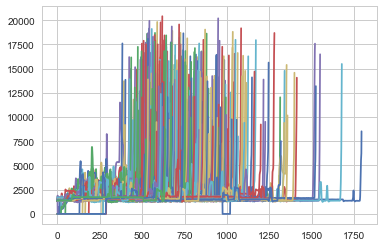

In [9]:
for data in liste_comp :
    plt.plot(data["FF_1"])
plt.show()

On observe que toutes les séries se terminent par un fort pic. On fait le choix de l'enlever car il n'apporte rien de significatif et risque de perturber l'analyse.

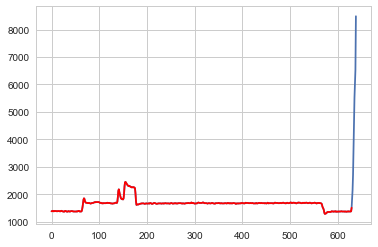

In [10]:
def enlever_pic(serie, seuil=10, pts_moy=2, plot=False) :
    """Retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. Les accroissements sont moyennés sur plusieurs points pour ne pas être sensibles 
    aux possibles irrégularités dans le pic.
    L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne le dataframe tronqué"""

    val_serie = serie["FF_1"].values
    if plot :
        plt.plot(val_serie)
        
    accr = abs(val_serie[1:] - val_serie[:-1])
    moy_accr = [np.mean(accr[i : i + pts_moy]) for i in range(len(accr) - pts_moy)]

    for ind, val in enumerate(moy_accr[::-1]) :
        if val < seuil and ind >= 1 :
            if plot :
                plt.plot(val_serie[:-ind], color="red")
                plt.show()
                
            return serie.drop(serie.index[-ind:])
            break
    else : 
        return serie
    
serie_test = liste_appr[14]
a = enlever_pic(serie_test, plot=True)
#plt.plot(a["FF_1"].values)
#plt.show()

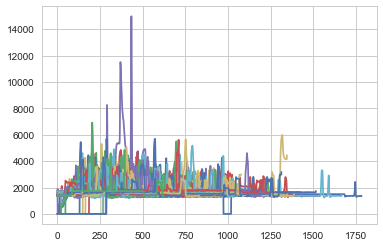

In [11]:
liste_comp = [enlever_pic(serie) for serie in liste_comp]
for data in liste_comp :
    plt.plot(data["FF_1"])
    
plt.show()

On peut voir qu'on a bien retiré tous les pics finaux.

Longueur des séries sans pic :

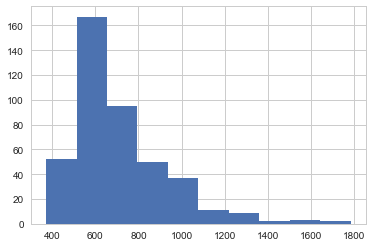

372


In [12]:
long = [serie.shape[0] for serie in liste_comp]
plt.hist(long)
plt.show()
longueur_min = min(long)
print(longueur_min)

Toutes les séries sont de longueur différente, difficile donc de réaliser une ACP directement. On va plutôt étudier les coefficients de Fourier des séries. Pour avoir une comparaison faite sur les mêmes bases de Fourier, on ne conserve que les premiers coefficients, ceux qui sont communs à toutes les séries.

## ACP sur les premiers coefficients de Fourier

In [13]:
X_signal = [list(serie["FF_1"].values) for serie in liste_comp]
#print(X_signal)  # On a une liste de listes, chaque liste est une série de données

In [14]:
fftCoeff = []

for x in X_signal :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre)[:longueur_min])
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)

print(fftCoeff.shape)

(428, 372)


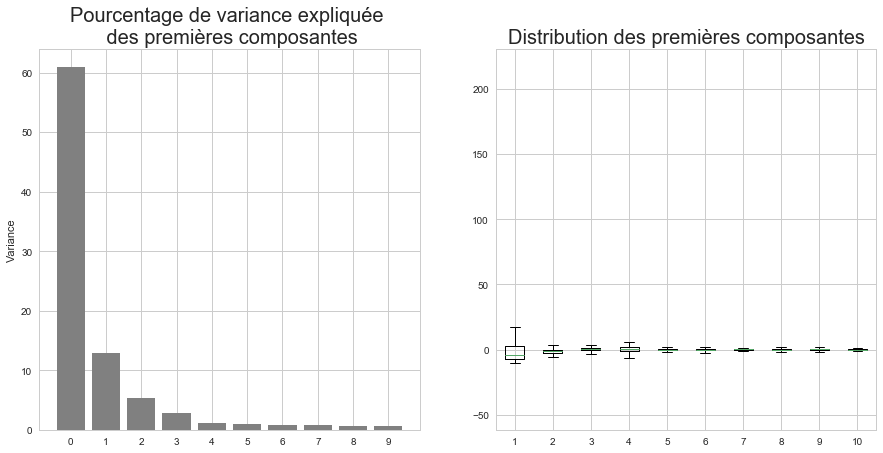

In [15]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff))
plot_var_ACP(X_acp_fft)

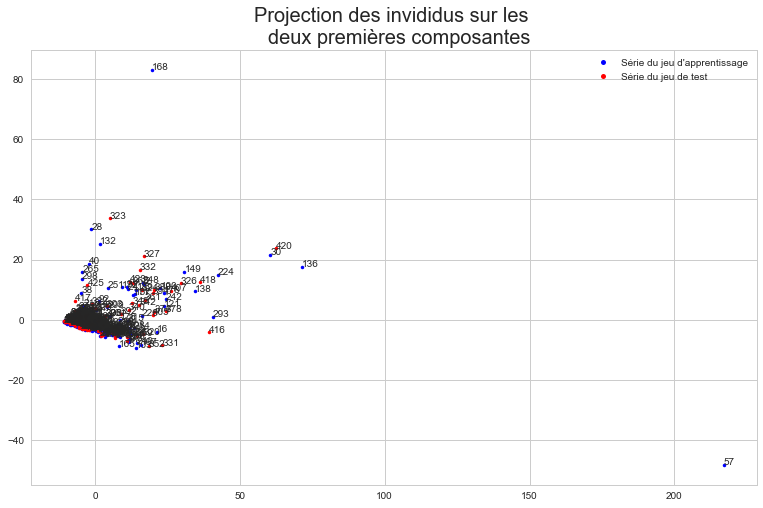

In [16]:
plot_proj_ACP(X_acp_fft)

Observation des signaux qui s'écartent des autres :

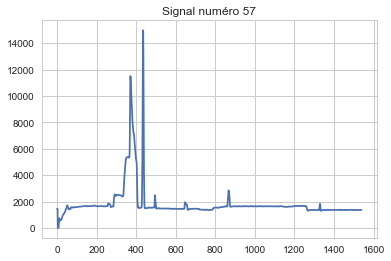

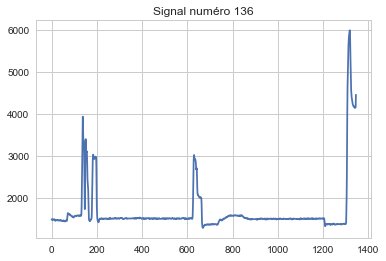

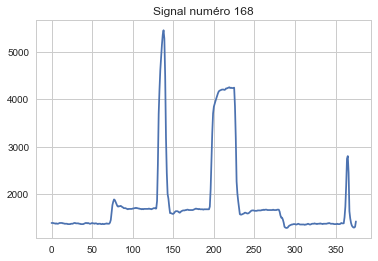

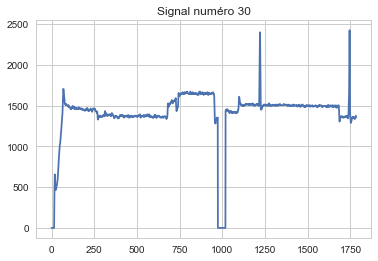

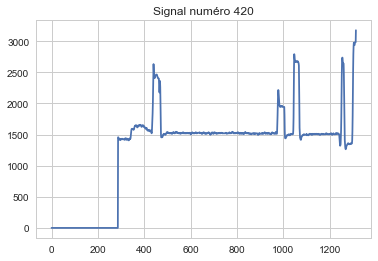

In [17]:
for num in [57, 136, 168, 30, 420] :
    data = liste_comp[num]
    plt.plot(data["FF_1"])
    plt.title("Signal numéro " + str(num))
    plt.show()

Très peu convainquant, les séries du jeu de test ne se différencient pas des autres. Par contre des séries du jeu d'apprentissage paraissent anormales, est-ce bien le comportement nominal du capteur ?

On peut essayer de refaire une ACP en enlevant ces données aberrantes :

In [18]:
import copy
liste_comp_nettoyee = copy.deepcopy(liste_comp)
for num in [57, 136, 168, 30] :
    del liste_comp_nettoyee[num]

In [19]:
X_signal = [list(serie["FF_1"].values) for serie in liste_comp_nettoyee]
#print(X_signal)  # On a une liste de listes, chaque liste est une série de données

In [20]:
fftCoeff = []

for x in X_signal :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre)[:longueur_min])
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)

print(fftCoeff.shape)

(424, 372)


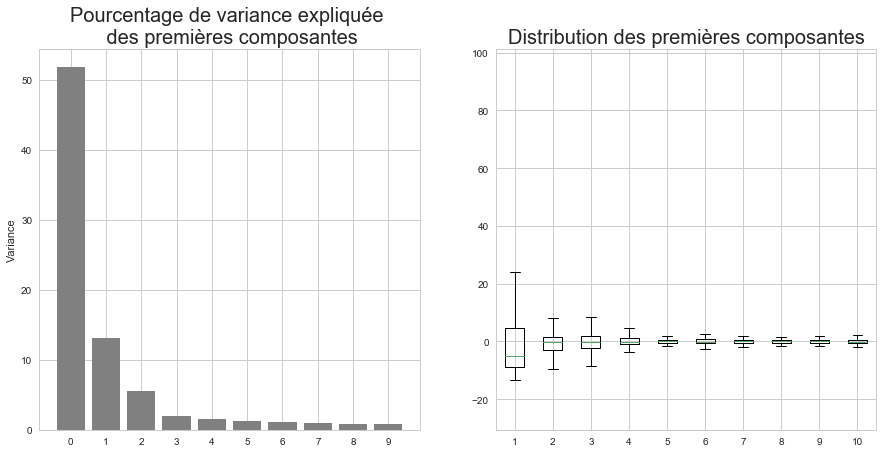

In [21]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff))
plot_var_ACP(X_acp_fft)

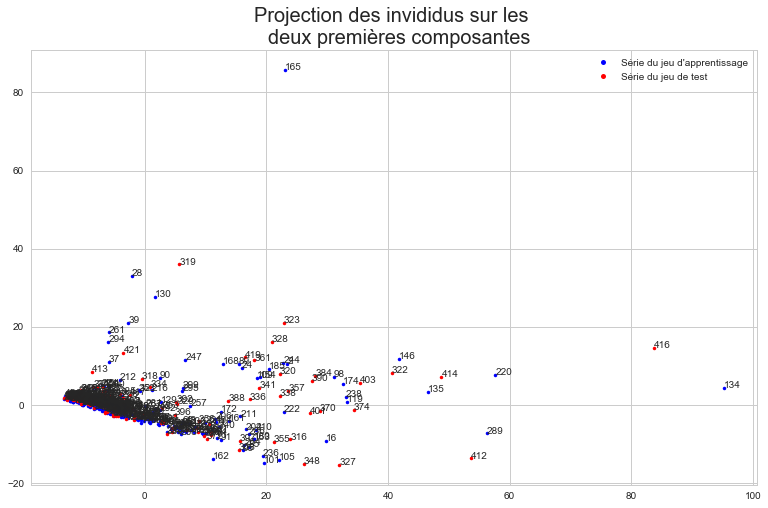

In [22]:
plot_proj_ACP(X_acp_fft, etiq=True)

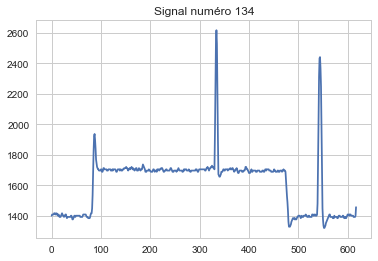

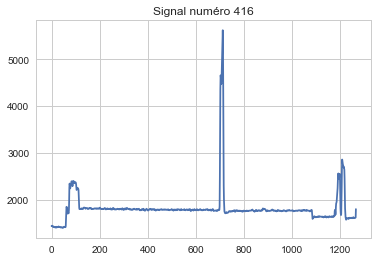

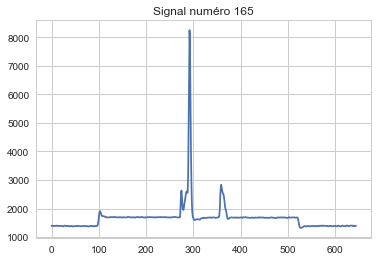

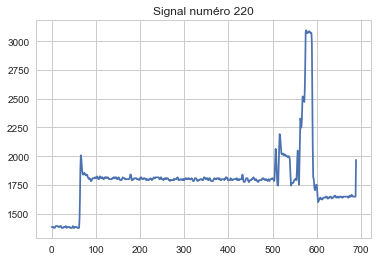

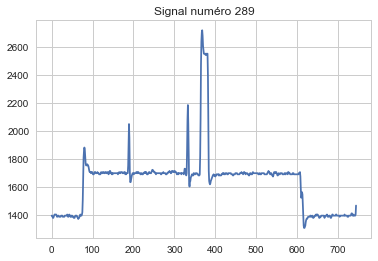

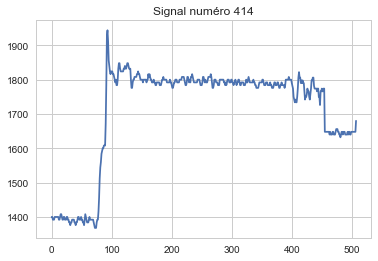

In [23]:
for num in [134, 416, 165, 220, 289, 414] :
    data = liste_comp[num]
    plt.plot(data["FF_1"])
    plt.title("Signal numéro " + str(num))
    plt.show()

A nouveau, on voit ressortir du nuage surtout des signaux provenant du jeu d'apprentissage. Ceux provenant du jeu de test commencent aussi à se disperser.

## ACP sur les coefficients de Fourier seuillés

On ne va garder que les 10% des coefficients les plus significatifs, c'est-à-dire ceux dont la somme des carrés est la plus grande sur l'ensemble des signaux.

In [24]:
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)

somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(424, 37)


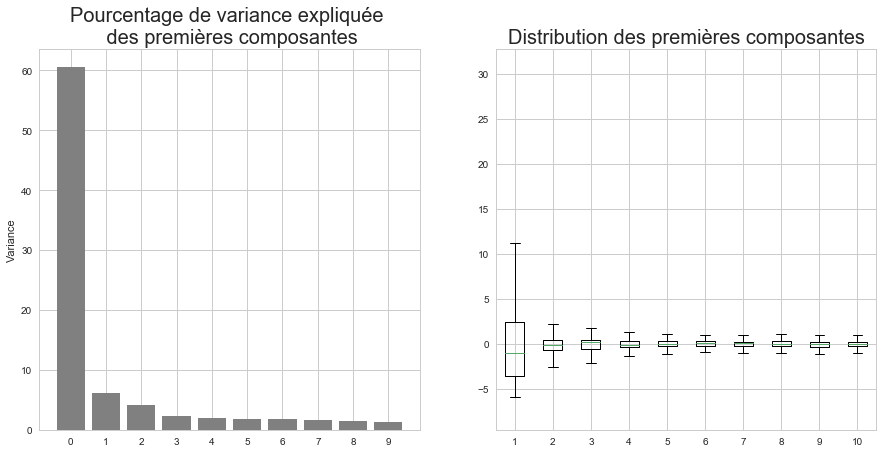

In [25]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff_seuil))
plot_var_ACP(X_acp_fft)

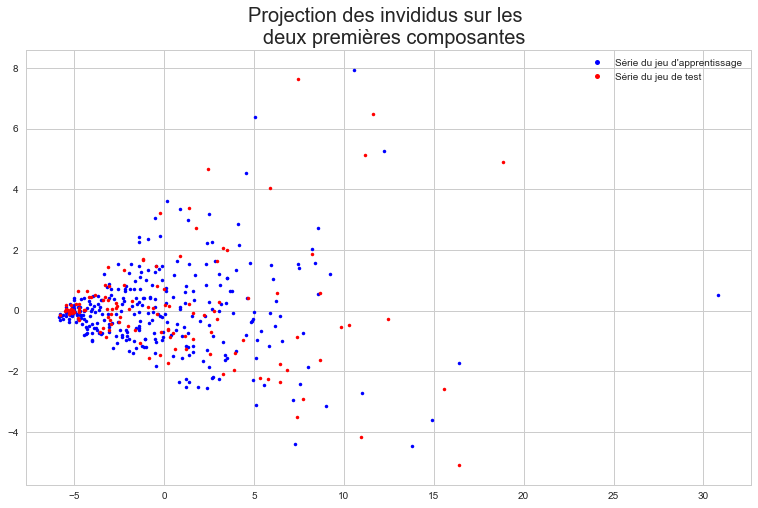

In [26]:
plot_proj_ACP(X_acp_fft, etiq=False)

La dispersion du nuage semble un peu meilleure mais on ne voit toujours rien qui permettrait de séparer les séries du jeu de test des autres.


# Classification ascendante hiérarchique sur les coefficients de Fourier

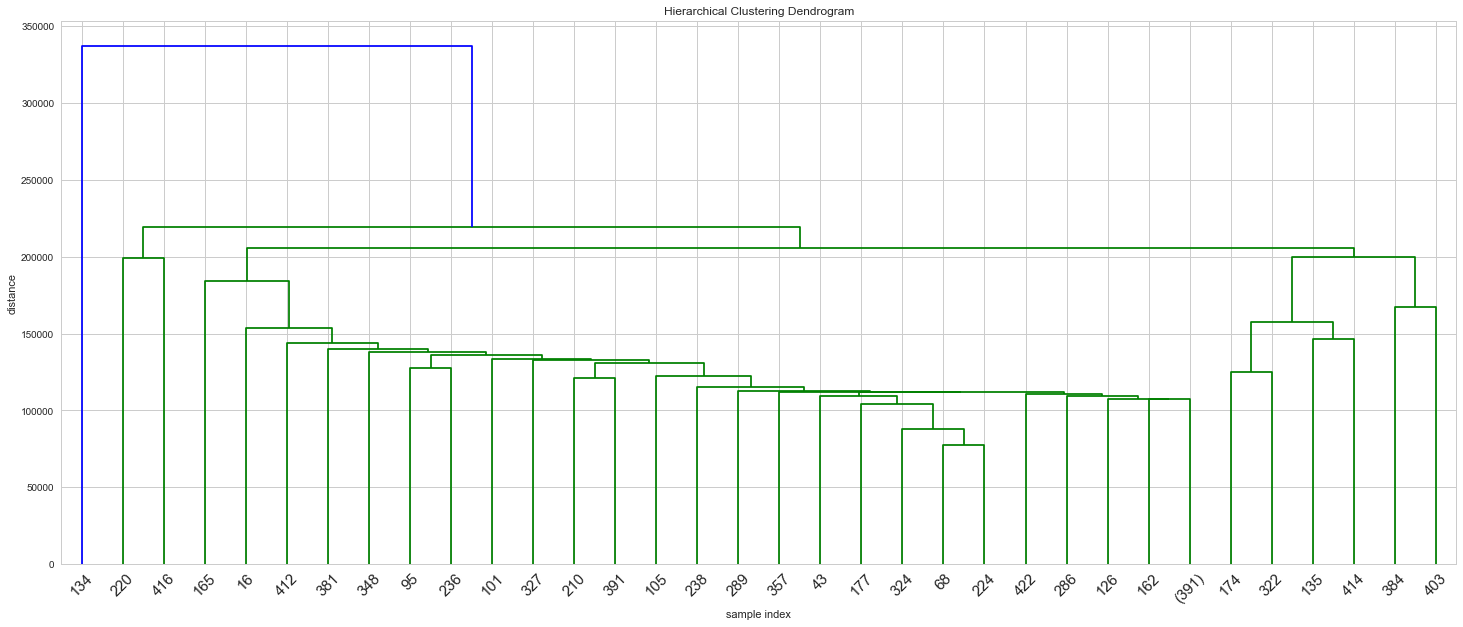

In [76]:
Z = sch.linkage(fftCoeff, 'single')
plot_dendro(Z)

Encore une fois, les signaux qui paraissent les plus anormaux sont ceux provenant du jeu d'apprentissage.

On observe toutefois que les signaux qui se détachent à droite du dendrogramme sont bien issus du jeu de test.

## Isolation Forest sur les coefficients de Fourier

In [31]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, behaviour="new", n_jobs=-1)
clf.fit(fftCoeff)
y_pred = clf.predict(fftCoeff)

CT_IF_Fourier = pd.DataFrame(list(y_pred), columns=["pred"])

TypeError: __init__() got an unexpected keyword argument 'behaviour'

In [25]:
clf.fit(fftCoeff_seuil)
y_pred = clf.predict(fftCoeff_seuil)

CT_IF_Fourier_seuil = pd.DataFrame(list(y_pred), columns=["pred"])

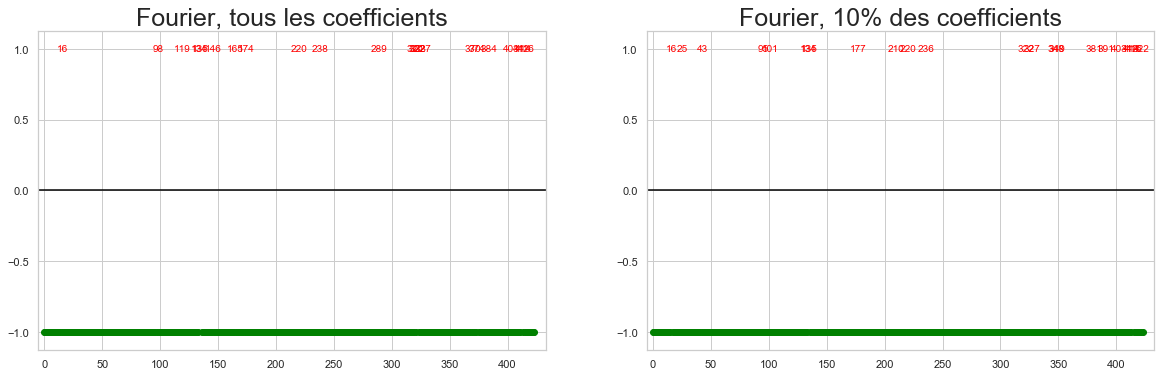

In [26]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
plot_result_IF(fig, ax, CT_IF_Fourier, title="Fourier, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,2)
plot_result_IF(fig, ax, CT_IF_Fourier_seuil, title="Fourier, 10% des coefficients", fontsize=25)

In [27]:
print("Anomalies avec tous les coefficients : ", CT_IF_Fourier[CT_IF_Fourier.pred==-1].index.values)
print("Anomalies avec 10% des coefficients : ", CT_IF_Fourier[CT_IF_Fourier_seuil.pred==-1].index.values)

Anomalies avec tous les coefficients :  [ 16  98 119 134 135 146 165 174 220 238 289 320 322 323 327 370 374 384
 403 412 414 416]
Anomalies avec 10% des coefficients :  [ 16  25  43  95 101 134 135 177 210 220 236 322 327 348 349 381 391 403
 412 414 416 422]


On obtient des résultats assez similaires avec ou sans seuillage, et la détection n'a pas l'air de fonctionner.

## Décomposition en ondelettes

In [56]:
X_signal = [list(serie["FF_1"].values) for serie in liste_comp]

In [57]:
wf = "haar"

Coeff = []
TCoeff = []

for x in X_signal:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)  #Niveau 8
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    
Coeff = np.array(Coeff)
print(Coeff.shape)

(428,)


### Choix des coefficients

Tous les signaux n'étant pas de même longueur, on est obligé de tronquer chaque signal pour réaliser l'ACP. On choisit d'abord autant de coefficients que la longueur du plus petit signal. Puis, on sélectionne une taille égale à la puissance de 2 la plus grande possible afin de rester dans une même base d'ondelette. 

In [59]:
longueur_max = min([len(x) for x in Coeff])
longueur_max=int(2**np.floor(np.log2(longueur_max)))
print(longueur_max)

256


In [60]:
Coeff = np.array([x[:longueur_max] for x in Coeff])

In [61]:
print(Coeff.shape)
print(np.sum(Coeff!=0))

(428, 256)
97097


## ACP sur les coefficients d'ondelettes

### Tous les coefficients

In [62]:
acp = sd.PCA()
X_acp_ond = acp.fit_transform(sp.scale(Coeff))

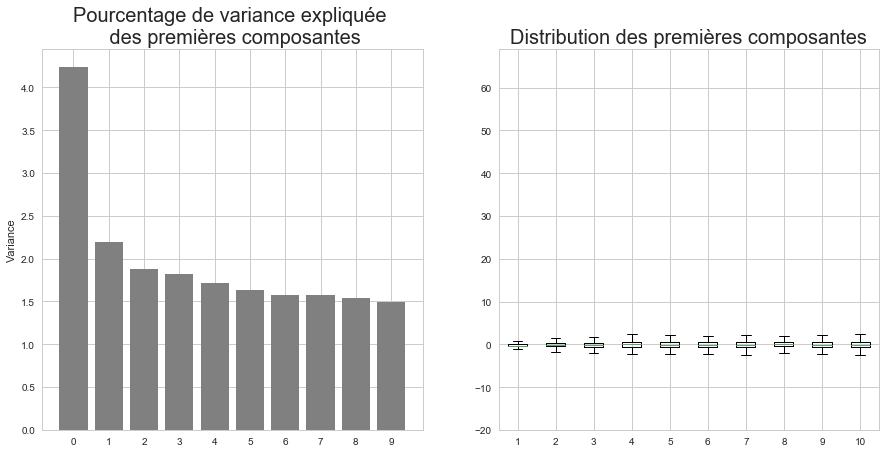

In [64]:
plot_var_ACP(X_acp_ond)

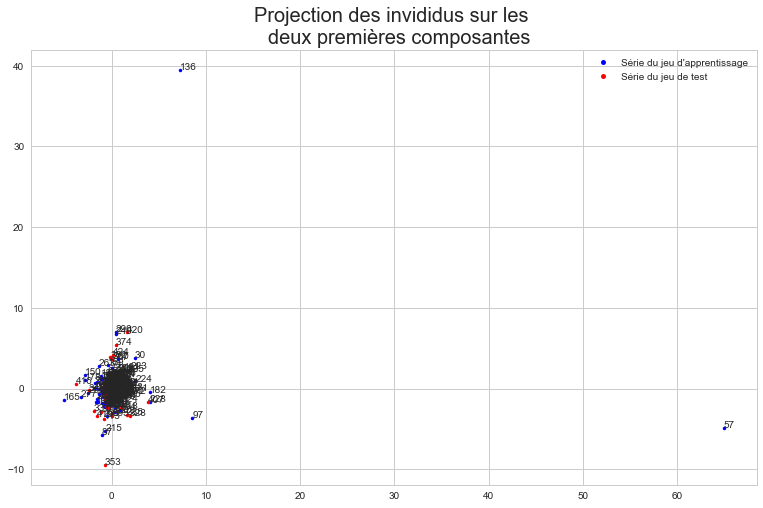

In [65]:
plot_proj_ACP(X_acp_ond)

### Ondelettes de niveau le plus fin J=7

In [66]:
#Coefficient de niveau 7 : 
Coeff7=Coeff[:,128:]

In [67]:
acp = sd.PCA()
X_acp_ond7 = acp.fit_transform(sp.scale(Coeff7))

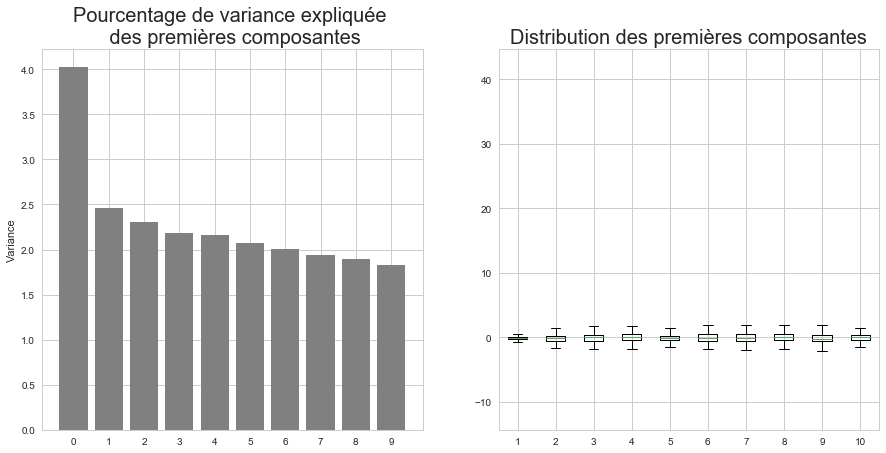

In [68]:
plot_var_ACP(X_acp_ond7)

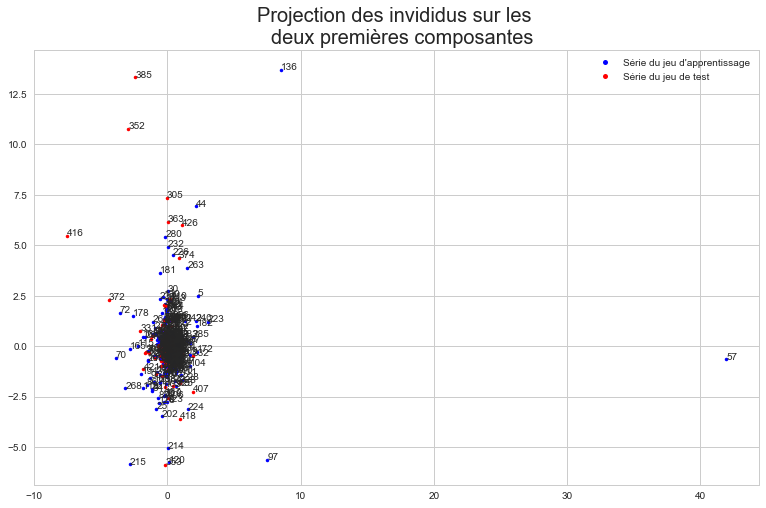

In [69]:
plot_proj_ACP(X_acp_ond7)

### Coefficients d'ondelettes de niveaux 1 à 4

In [70]:
#Coefficient de niveau 1 à 4 : 
CoeffA4=Coeff[:,:16]

In [71]:
acp = sd.PCA()
X_acp_ondA4 = acp.fit_transform(sp.scale(CoeffA4))

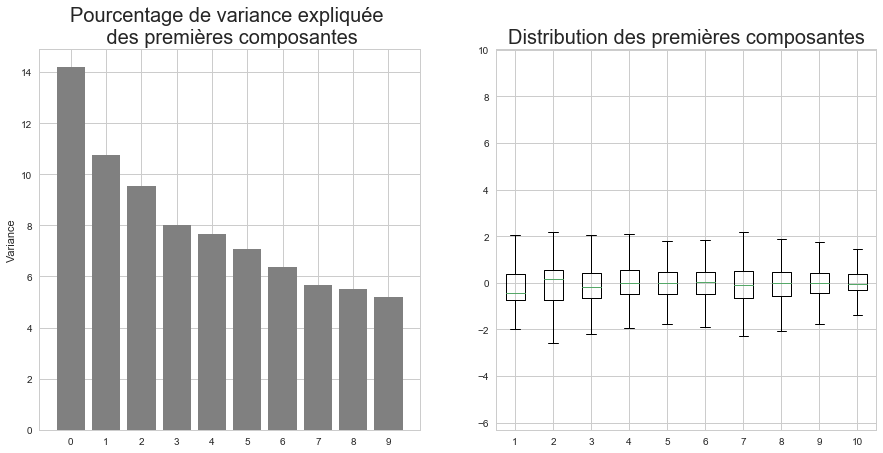

In [72]:
plot_var_ACP(X_acp_ondA4)

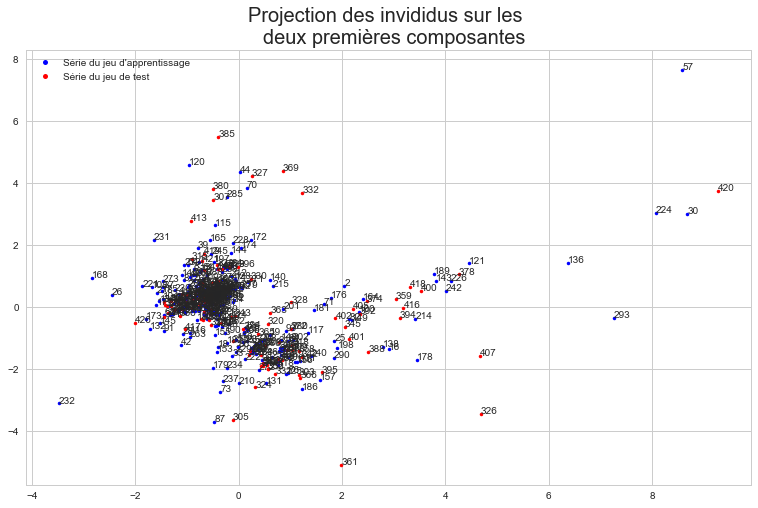

In [73]:
plot_proj_ACP(X_acp_ondA4)

## CAH sur les coefficients d'ondelettes

### Tous les coefficients

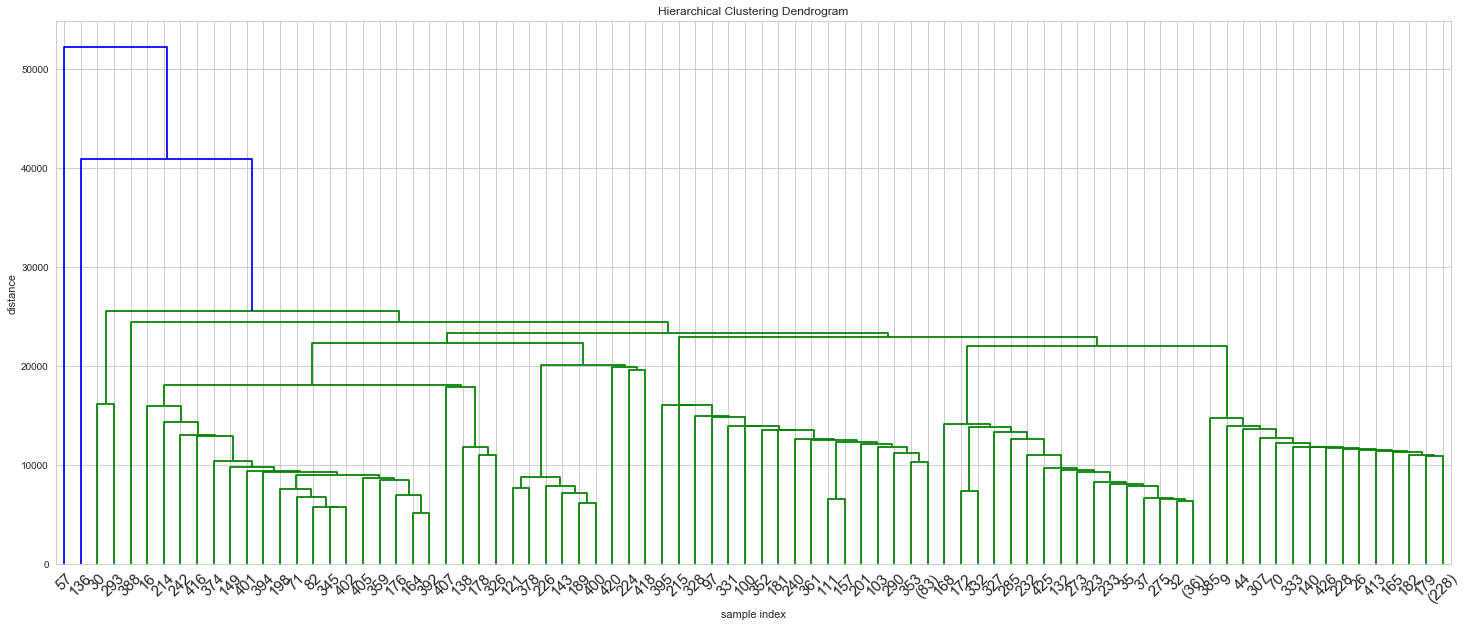

In [77]:
Z = sch.linkage(Coeff, 'single')
plot_dendro(Z)

### Ondelettes de niveau le plus fin J=7

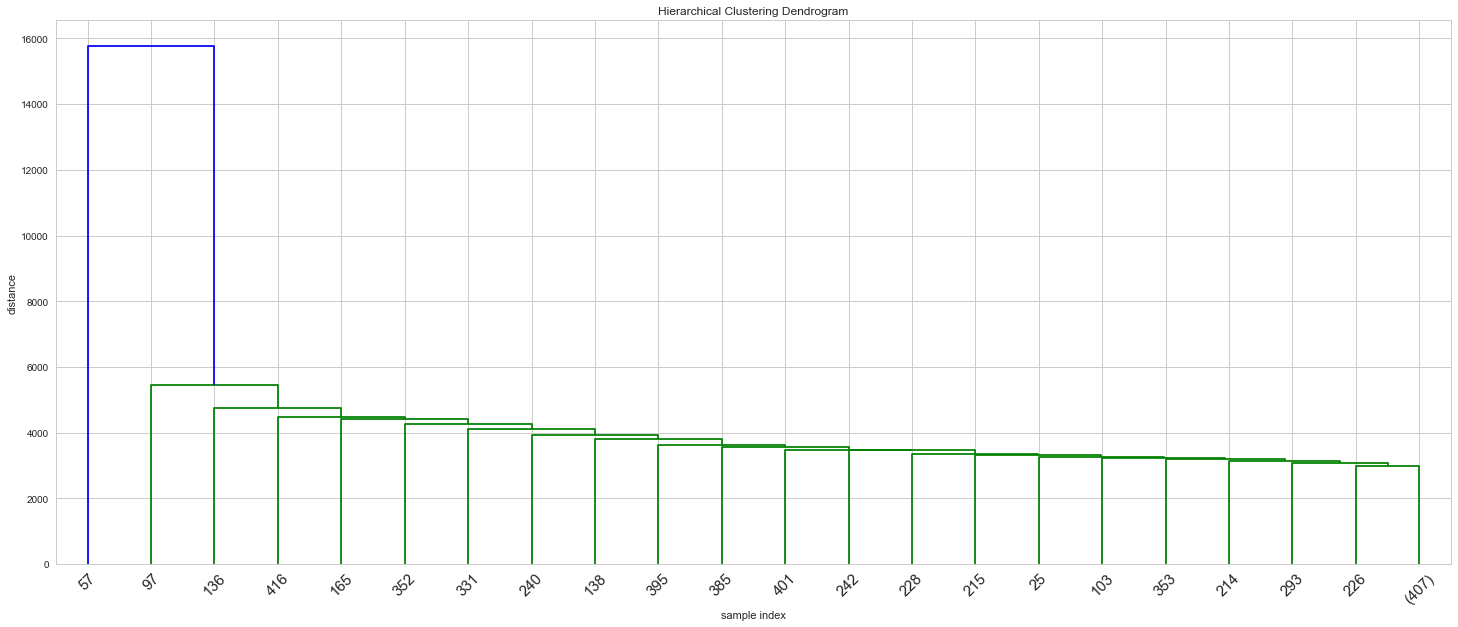

In [78]:
Z = sch.linkage(Coeff7, 'single')
plot_dendro(Z)

### Coefficients d'ondelettes de niveaux 1 à 4

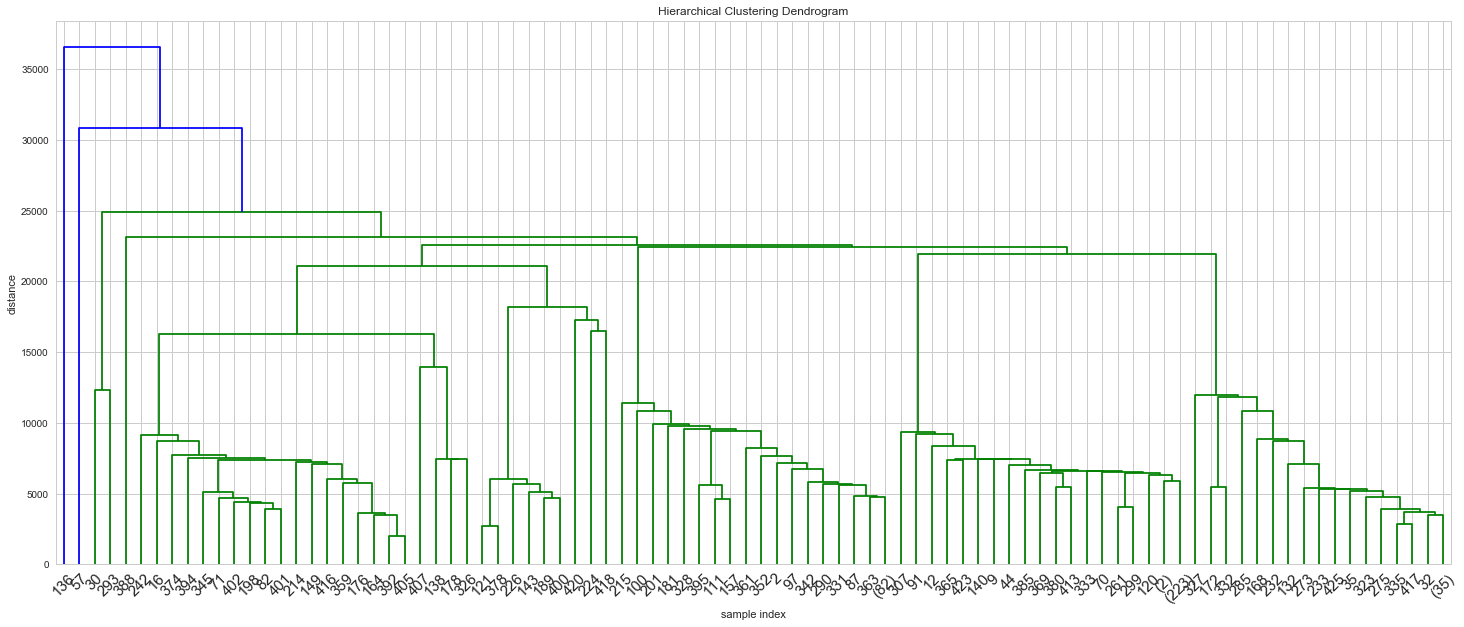

In [79]:
Z = sch.linkage(CoeffA4, 'single')
plot_dendro(Z)

## Isolation Forest sur les coefficients d'ondelettes

### Tous les coefficients

In [80]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)
clf.fit(Coeff)
y_pred = clf.predict(Coeff)

CT_IF_ond = pd.DataFrame(list(y_pred), columns=["pred"])

### Ondelettes de niveau le plus fin J=7

In [81]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)
clf.fit(Coeff7)
y_pred = clf.predict(Coeff7)

CT_IF_ond7 = pd.DataFrame(list(y_pred), columns=["pred"])

### Coefficients d'ondelettes de niveaux 1 à 4

In [82]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)
clf.fit(CoeffA4)
y_pred = clf.predict(CoeffA4)

CT_IF_ondA4 = pd.DataFrame(list(y_pred), columns=["pred"])

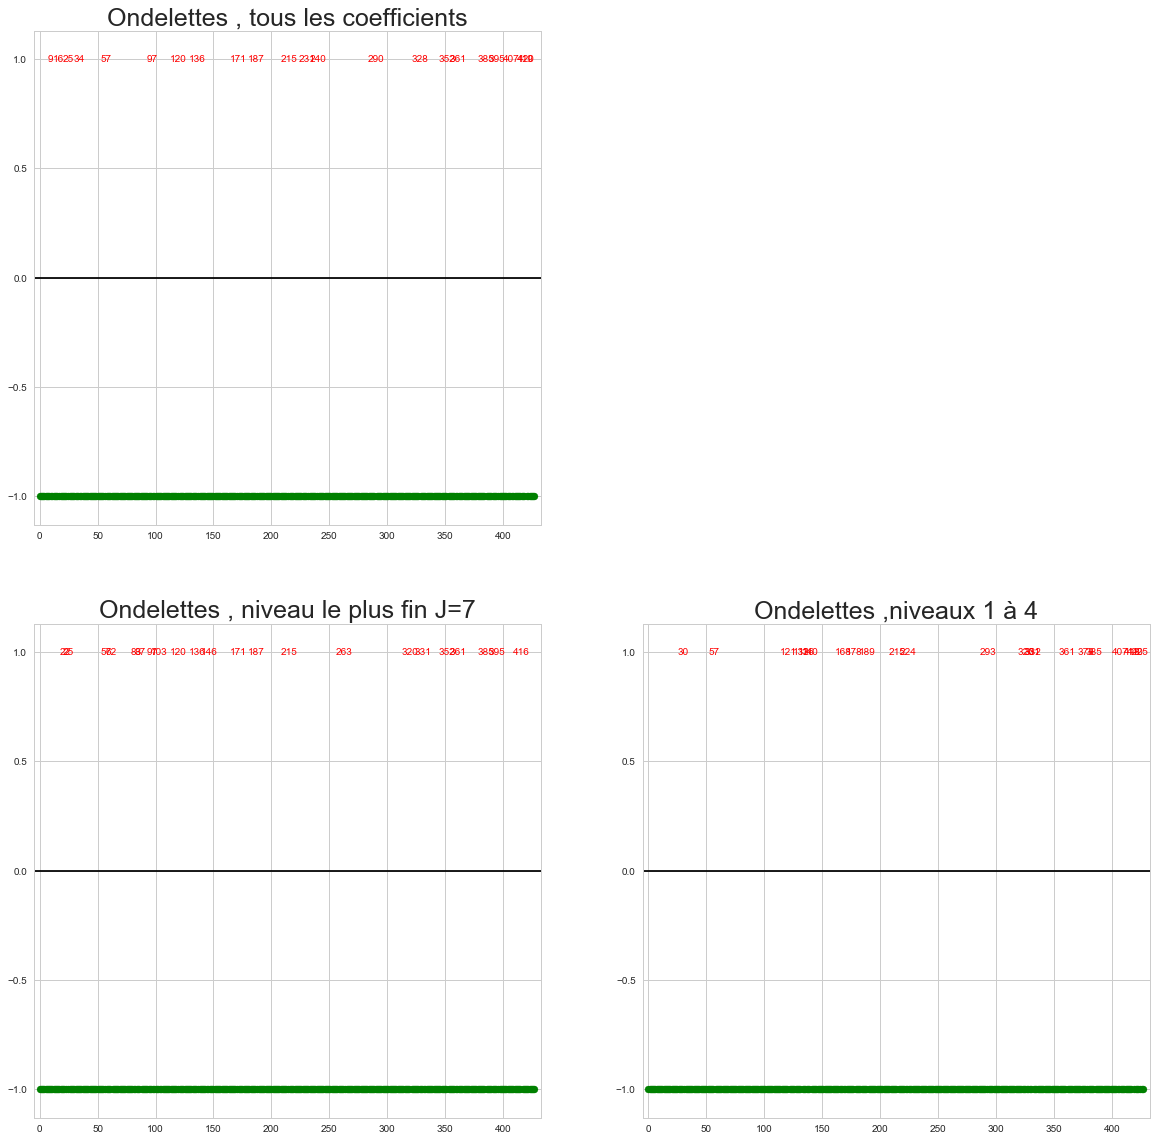

In [83]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,2,1)
plot_result_IF(fig, ax, CT_IF_ond, title="Ondelettes , tous les coefficients", fontsize=25)
ax = fig.add_subplot(2,2,3)
plot_result_IF(fig, ax, CT_IF_ond7, title="Ondelettes , niveau le plus fin J=7", fontsize=25)
ax = fig.add_subplot(2,2,4)
plot_result_IF(fig, ax, CT_IF_ondA4, title="Ondelettes ,niveaux 1 à 4", fontsize=25)

In [84]:
print("Anomalies avec tous les coefficients : ", CT_IF_ond[CT_IF_ond.pred==-1].index.values)
print("Anomalies avec coefficients de niveau le plus fin J=7: ", CT_IF_ond7[CT_IF_ond7.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 4: ", CT_IF_ondA4[CT_IF_ondA4.pred==-1].index.values)

Anomalies avec tous les coefficients :  [  9  16  25  34  57  97 120 136 171 187 215 231 240 290 328 352 361 385
 395 407 419 420]
Anomalies avec coefficients de niveau le plus fin J=7:  [ 22  25  57  62  83  87  97 103 120 136 146 171 187 215 263 320 331 352
 361 385 395 416]
Anomalies avec coefficients de niveaux 1 à 4:  [ 30  57 121 132 136 140 168 178 189 215 224 293 326 331 332 361 378 385
 407 418 420 425]
